Qualitative Takeways:

It can be seen that the first split is on Po1. This hints towards the fact that higher crime areas have higher police expenditure. Please remember the difference between correlation and causation.

And since it is a decision tree, it is a weak learner and highly overfits the data.

Also note that Pop is used at two places. Even Po1 is used in two places.

In [1]:
suppressWarnings(suppressMessages(library("tree")))
suppressWarnings(suppressMessages(library("randomForest")))
suppressWarnings(suppressMessages(require(pROC)))

In [2]:
#reading the US crime dataset
us_crime <- read.table("uscrime.txt", header = T)

In [3]:
#building a full decision tree without any kind of pruning
model_tree <- tree(Crime ~., us_crime)

In [4]:
summary(model_tree)


Regression tree:
tree(formula = Crime ~ ., data = us_crime)
Variables actually used in tree construction:
[1] "Po1" "Pop" "LF"  "NW" 
Number of terminal nodes:  7 
Residual mean deviance:  47390 = 1896000 / 40 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-573.900  -98.300   -1.545    0.000  110.600  490.100 

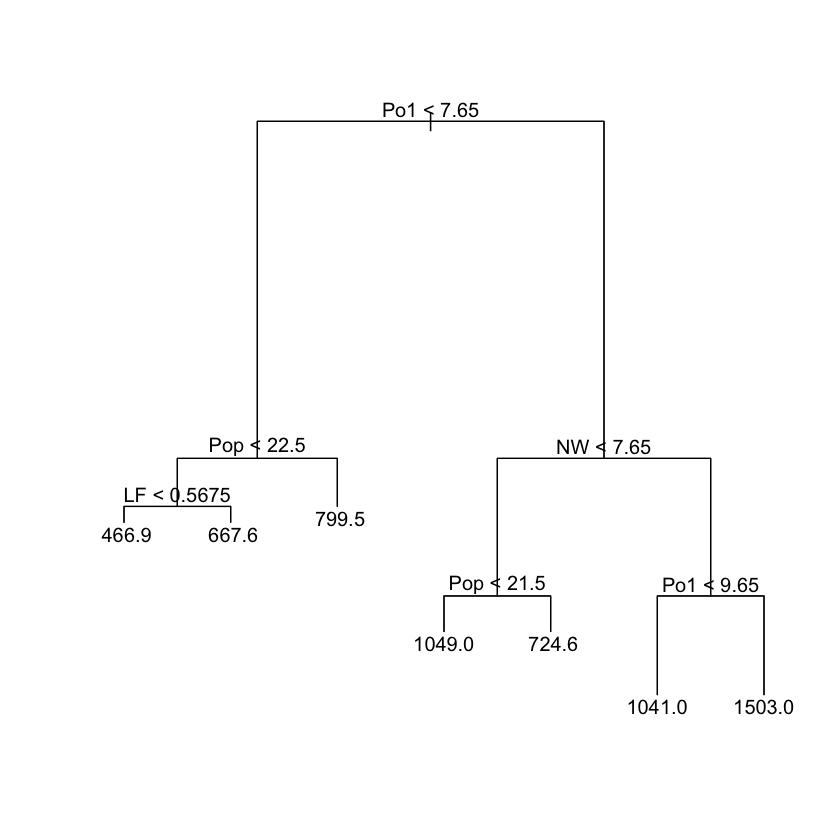

In [5]:
plot(model_tree)
text(model_tree)

In [6]:
#Function to calculate R2
compute_rsquared <- function(y_hat, y){
    SSR <- sum((y_hat - y)^2)
    SST <- sum((y - mean(y))^2)
    rsquared <- 1 - SSR/SST
    return (rsquared)
}

In [7]:
#getting the prediction from our tree model
y_hat_tree <- predict(model_tree)

In [8]:
y <- us_crime$Crime

In [9]:
#getting the rsquared for the whole decision tree in general
compute_rsquared(y_hat_tree, y)

[1] 0.7244962

In [10]:
print(model_tree$frame)

      var  n        dev      yval splits.cutleft splits.cutright
1     Po1 47 6880927.66  905.0851          <7.65           >7.65
2     Pop 23  779243.48  669.6087          <22.5           >22.5
4      LF 12  243811.00  550.5000        <0.5675         >0.5675
8  <leaf>  7   48518.86  466.8571                               
9  <leaf>  5   77757.20  667.6000                               
5  <leaf> 11  179470.73  799.5455                               
3      NW 24 3604162.50 1130.7500          <7.65           >7.65
6     Pop 10  557574.90  886.9000          <21.5           >21.5
12 <leaf>  5  146390.80 1049.2000                               
13 <leaf>  5  147771.20  724.6000                               
7     Po1 14 2027224.93 1304.9286          <9.65           >9.65
14 <leaf>  6  170828.00 1041.0000                               
15 <leaf>  8 1124984.88 1502.8750                               


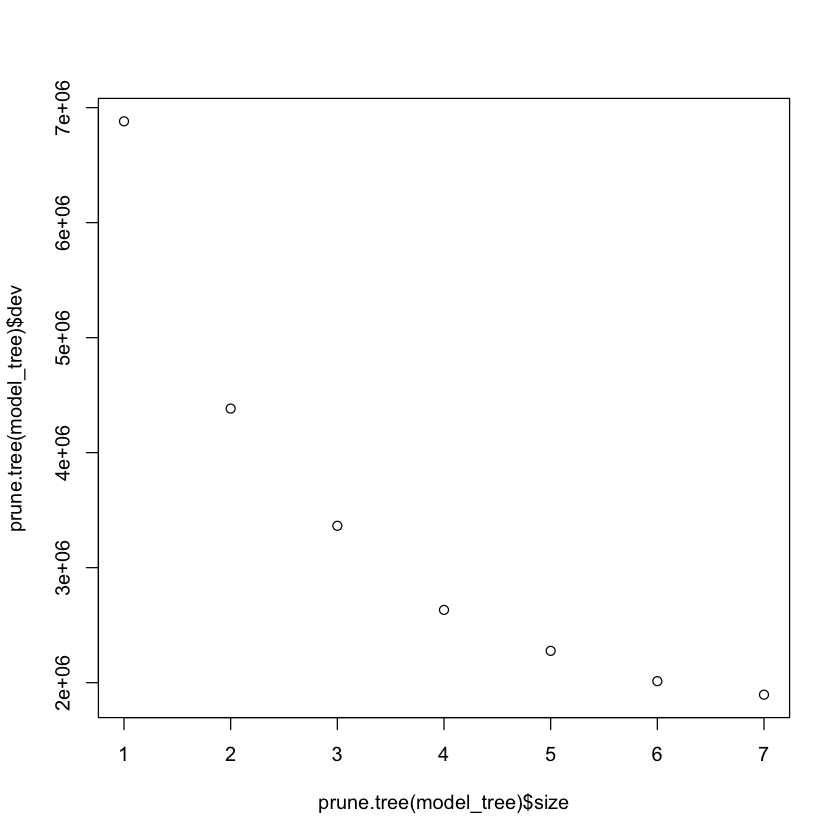

In [11]:
plot(prune.tree(model_tree)$size, prune.tree(model_tree)$dev)

In [12]:
#From the above plot it can be seen that the tree can be pruned at 4
tree_pruned <- prune.tree(model_tree, best = 4)

In [13]:
summary(tree_pruned)


Regression tree:
snip.tree(tree = model_tree, nodes = c(6L, 2L))
Variables actually used in tree construction:
[1] "Po1" "NW" 
Number of terminal nodes:  4 
Residual mean deviance:  61220 = 2633000 / 43 
Distribution of residuals:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-573.90 -152.60   35.39    0.00  158.90  490.10 

In [14]:
y_hat_pruned <- predict(tree_pruned)

In [15]:
compute_rsquared(y_hat_pruned, y)

[1] 0.6174017

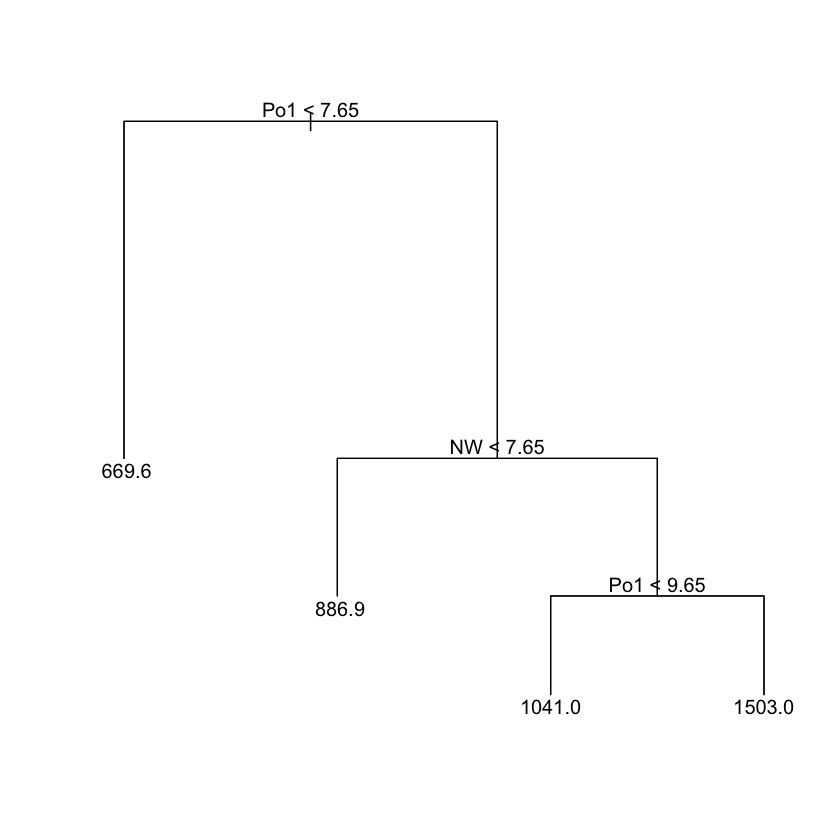

In [16]:
plot(tree_pruned)
text(tree_pruned)

In [17]:
#Let's do a regression on the first leaf data from the left for decision tree.
leaf1 <- us_crime[us_crime$Po1 <7.65,]

#performing linear regression on the this data
linear_model <- lm(Crime~., data = leaf1)
summary(linear_model)



Call:
lm(formula = Crime ~ ., data = leaf1)

Residuals:
     Min       1Q   Median       3Q      Max 
-109.147  -52.803   -6.495   53.784  127.196 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)   -48.5477  2044.9766  -0.024   0.9817  
M              45.8622    58.6256   0.782   0.4597  
So            380.4815   223.1072   1.705   0.1319  
Ed            187.9074    89.5799   2.098   0.0741 .
Po1            -3.5138   157.7513  -0.022   0.9829  
Po2            44.6382   148.5528   0.300   0.7725  
LF           1059.3652  1187.9722   0.892   0.4021  
M.F           -22.5521    21.4677  -1.051   0.3284  
Pop            10.6413     5.0929   2.089   0.0750 .
NW              0.1010     7.9019   0.013   0.9902  
U1           4878.2802  4874.8165   1.001   0.3503  
U2             -5.5126   133.5094  -0.041   0.9682  
Wealth         -0.1022     0.1752  -0.583   0.5779  
Ineq            4.7779    35.5290   0.134   0.8968  
Prob        -7317.4407  3280.7511  -2.230

In [18]:
#We are getting rsquared of 0.8794... quite good.

In [19]:
### moving on to randomforest

#professor mentioned we generally use 1+log(n) features

num_features <- 1 + log(ncol(us_crime))
rf_model <- randomForest(Crime~., data = us_crime, mtry = num_features, importance = T, ntree = 600)
rf_model


Call:
 randomForest(formula = Crime ~ ., data = us_crime, mtry = num_features,      importance = T, ntree = 600) 
               Type of random forest: regression
                     Number of trees: 600
No. of variables tried at each split: 4

          Mean of squared residuals: 83595.78
                    % Var explained: 42.9

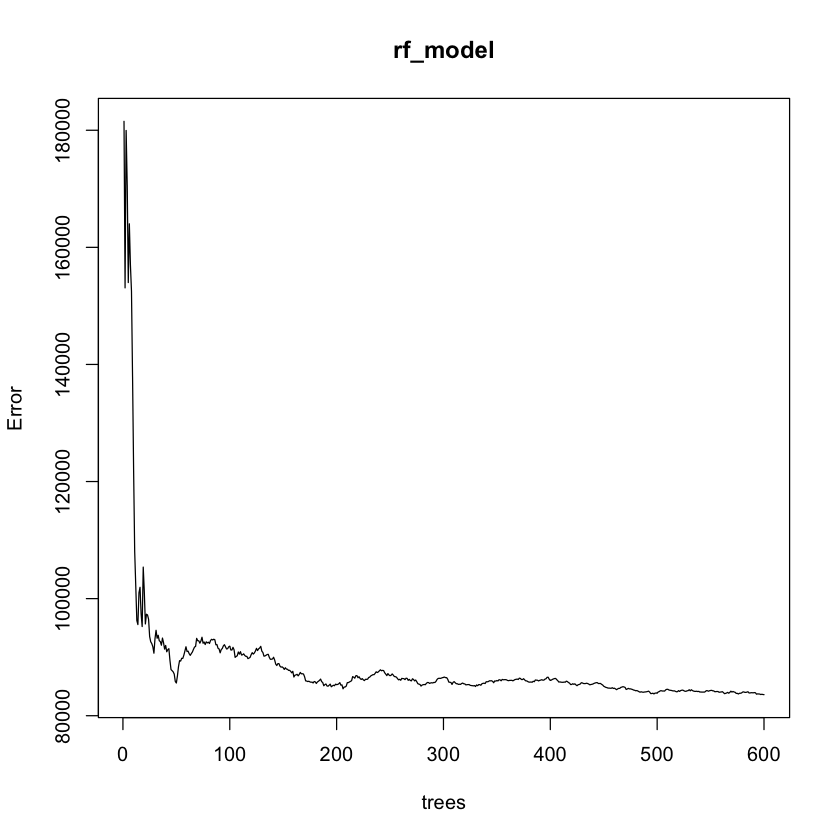

In [20]:
plot(rf_model)

In [21]:
##it can seen that the error flattens out at nearly 250 trees. 

In [22]:
y_rf <- predict(rf_model)
compute_rsquared(y_rf, y)

[1] 0.4290012

In [23]:
##we are not getting a very high rsquared value. I'm assuming this would be due to good generalization property
##of random forest. We though we are getting low rsqured value, it may be able to generalize well on test data

In [24]:
importance(rf_model)

,%IncMSE,IncNodePurity
M,2.71718885,204654.60
So,2.79747368,25524.24
Ed,3.19063979,299459.44
Po1,11.26052677,1164577.61
Po2,11.59805130,1028113.22
LF,4.10407505,274845.70
M.F,1.44406694,327424.98
Pop,2.39911736,363768.27
NW,8.99770627,503117.25
U1,0.02594937,145775.67


In [25]:
###We have the features ranked as per feature importance scores professor discussed during the class.

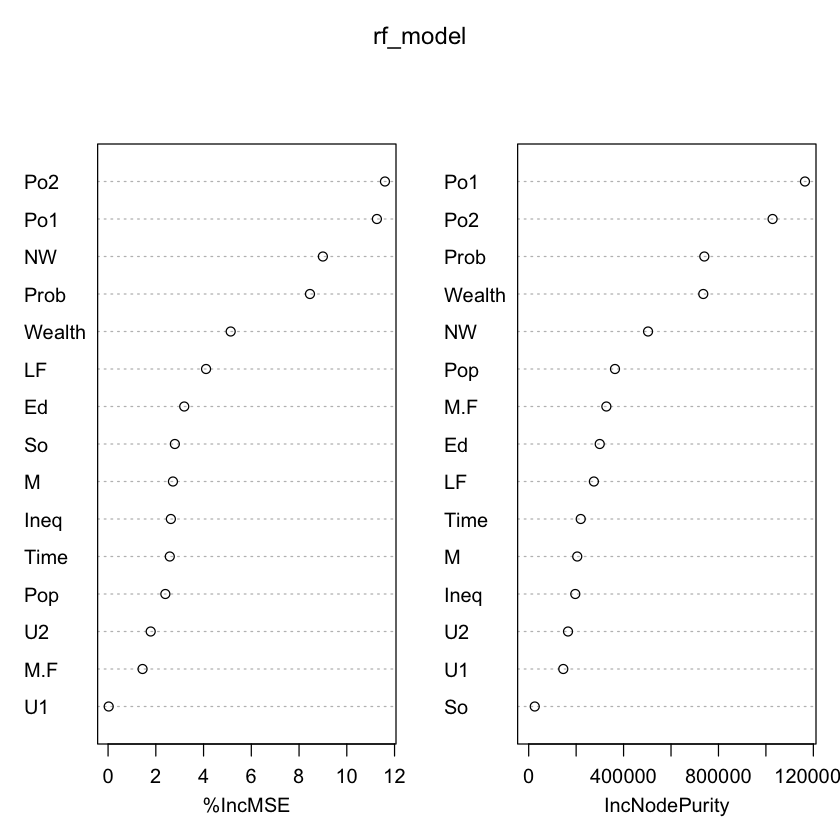

In [26]:
varImpPlot(rf_model)

## 10.2

I work as a Data Scientist for a small business lender. We mainly use logistic regression to predict the probability of default and price the loan accordingly. Main features that go into our model -- FICO, Company FICO score, Length of credit history, % utilization, Time in business, Commercial Email ID flag (which is either 0 or 1), home based business, risky industry, etc.

In [27]:
#reading the german credit data

german <- read.table("germancredit.txt", header = F)

In [28]:
head(german)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21
A11,6,A34,A43,1169,A65,A75,4,A93,A101,⋯,A121,67,A143,A152,2,A173,1,A192,A201,1
A12,48,A32,A43,5951,A61,A73,2,A92,A101,⋯,A121,22,A143,A152,1,A173,1,A191,A201,2
A14,12,A34,A46,2096,A61,A74,2,A93,A101,⋯,A121,49,A143,A152,1,A172,2,A191,A201,1
A11,42,A32,A42,7882,A61,A74,2,A93,A103,⋯,A122,45,A143,A153,1,A173,2,A191,A201,1
A11,24,A33,A40,4870,A61,A73,3,A93,A101,⋯,A124,53,A143,A153,2,A173,2,A191,A201,2
A14,36,A32,A46,9055,A65,A73,2,A93,A101,⋯,A124,35,A143,A153,1,A172,2,A192,A201,1


In [29]:
### 1 -> good
### 0 -> bad
german$V21[german$V21 == 2] <- 0

In [46]:
#splitting the data into train and test

mask <- sample(1:nrow(german), size = round(0.8*nrow(german)))
train <- german[mask,]
test <- german[-mask,]

In [47]:
#building a logistic regression using all features
logistic_full <- glm(V21 ~., family = binomial(link="logit"), train)
summary(logistic_full)


Call:
glm(formula = V21 ~ ., family = binomial(link = "logit"), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7251  -0.6673   0.3393   0.6834   2.5424  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.287815   1.253466   0.230 0.818391    
V1A12        0.218067   0.249399   0.874 0.381918    
V1A13        1.069835   0.425221   2.516 0.011871 *  
V1A14        1.760467   0.264063   6.667 2.61e-11 ***
V2          -0.025282   0.010574  -2.391 0.016804 *  
V3A31       -0.689345   0.629710  -1.095 0.273647    
V3A32        0.152510   0.509832   0.299 0.764835    
V3A33        0.201200   0.545822   0.369 0.712412    
V3A34        0.877855   0.510166   1.721 0.085301 .  
V4A41        1.976494   0.440298   4.489 7.16e-06 ***
V4A410       1.667881   0.879396   1.897 0.057878 .  
V4A42        0.947220   0.296466   3.195 0.001398 ** 
V4A43        0.990205   0.279431   3.544 0.000395 ***
V4A44        1.338258   0.980102   1

In [48]:
yhat_logit <- predict(logistic_full, test, type = "response")
yhat1 <- as.integer(yhat_logit > 0.5)

In [49]:
table(yhat1, test$V21)

     
yhat1   0   1
    0  29  25
    1  34 112


Call:
roc.default(response = test$V21, predictor = yhat1)

Data: yhat1 in 63 controls (test$V21 0) < 137 cases (test$V21 1).
Area under the curve: 0.6389

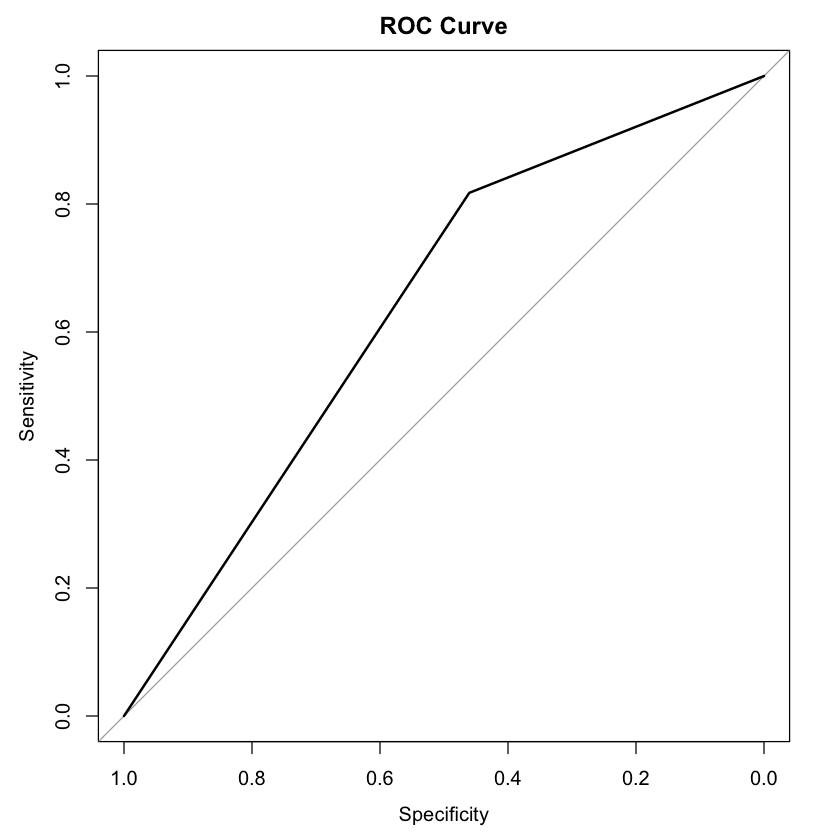

In [50]:
AUC <- roc(test$V21, yhat1)
plot(AUC, main = "ROC Curve")
AUC

In [51]:
#getting AUC of 0.6795

In [52]:
#Lets perform stepwise feature selection

In [53]:
step_selection <- step(logistic_full)
step_selection

Start:  AIC=795.58
V21 ~ V1 + V2 + V3 + V4 + V5 + V6 + V7 + V8 + V9 + V10 + V11 + 
    V12 + V13 + V14 + V15 + V16 + V17 + V18 + V19 + V20

       Df Deviance    AIC
- V17   3   699.02 791.02
- V12   3   700.08 792.08
- V11   1   697.61 793.61
- V13   1   698.02 794.02
- V15   2   700.92 794.92
- V20   1   699.55 795.55
<none>      697.58 795.58
- V7    4   706.10 796.10
- V16   1   700.31 796.31
- V18   1   700.44 796.44
- V14   2   702.47 796.47
- V19   1   700.80 796.80
- V2    1   703.31 799.31
- V10   2   705.64 799.64
- V6    4   709.80 799.80
- V3    4   710.50 800.50
- V5    1   706.17 802.17
- V8    1   709.51 805.51
- V9    3   717.33 809.33
- V4    9   737.22 817.22
- V1    3   756.71 848.71

Step:  AIC=791.02
V21 ~ V1 + V2 + V3 + V4 + V5 + V6 + V7 + V8 + V9 + V10 + V11 + 
    V12 + V13 + V14 + V15 + V16 + V18 + V19 + V20

       Df Deviance    AIC
- V12   3   701.46 787.46
- V11   1   699.12 789.12
- V13   1   699.51 789.51
- V15   2   701.99 789.99
- V7    4   706.65 790.6


Call:  glm(formula = V21 ~ V1 + V2 + V3 + V4 + V5 + V6 + V8 + V9 + V10 + 
    V14 + V16 + V18 + V19 + V20, family = binomial(link = "logit"), 
    data = train)

Coefficients:
(Intercept)        V1A12        V1A13        V1A14           V2        V3A31  
  0.0441945    0.2388626    1.1600621    1.8121385   -0.0236041   -0.4297243  
      V3A32        V3A33        V3A34        V4A41       V4A410        V4A42  
  0.3496435    0.3298881    1.0903558    1.8942955    1.5476404    0.8017031  
      V4A43        V4A44        V4A45        V4A46        V4A48        V4A49  
  0.9851493    1.3026093    0.8443589   -0.4139333    2.2054987    1.0553868  
         V5        V6A62        V6A63        V6A64        V6A65           V8  
 -0.0001535    0.1877285    0.4494764    1.2748453    0.8580731   -0.3364325  
      V9A92        V9A93        V9A94      V10A102      V10A103      V14A142  
  0.5327769    1.4948794    0.7953559   -0.7816908    1.0379722    0.1447681  
    V14A143          V16         

In [54]:
logistic_feature_selection <- glm(formula = V21 ~ V1 + V2 + V3 + V4 + V5 + V6 + V8 + V9 + V13 + 
    V14 + V20, family = binomial(link = "logit"), data = train)

In [55]:
summary(logistic_feature_selection)


Call:
glm(formula = V21 ~ V1 + V2 + V3 + V4 + V5 + V6 + V8 + V9 + V13 + 
    V14 + V20, family = binomial(link = "logit"), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8165  -0.7443   0.3860   0.7205   2.1132  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.329e+00  8.081e-01  -1.645 0.100069    
V1A12        3.517e-01  2.361e-01   1.490 0.136235    
V1A13        1.176e+00  4.099e-01   2.869 0.004121 ** 
V1A14        1.810e+00  2.536e-01   7.138 9.48e-13 ***
V2          -2.088e-02  9.824e-03  -2.125 0.033562 *  
V3A31       -3.316e-01  5.781e-01  -0.574 0.566171    
V3A32        5.244e-01  4.661e-01   1.125 0.260527    
V3A33        2.893e-01  5.225e-01   0.554 0.579810    
V3A34        1.023e+00  4.856e-01   2.107 0.035086 *  
V4A41        1.872e+00  4.190e-01   4.467 7.92e-06 ***
V4A410       1.527e+00  8.157e-01   1.872 0.061272 .  
V4A42        8.547e-01  2.792e-01   3.061 0.002206 ** 
V4A43        1.069

In [56]:
yhat_logit_feature_selection <- predict(logistic_feature_selection, test, type = "response")
yhat2 <- as.integer(yhat_logit_feature_selection > 0.5)

In [57]:
table(yhat2, test$V21)

     
yhat2   0   1
    0  28  19
    1  35 118


Call:
roc.default(response = test$V21, predictor = yhat2)

Data: yhat2 in 63 controls (test$V21 0) < 137 cases (test$V21 1).
Area under the curve: 0.6529

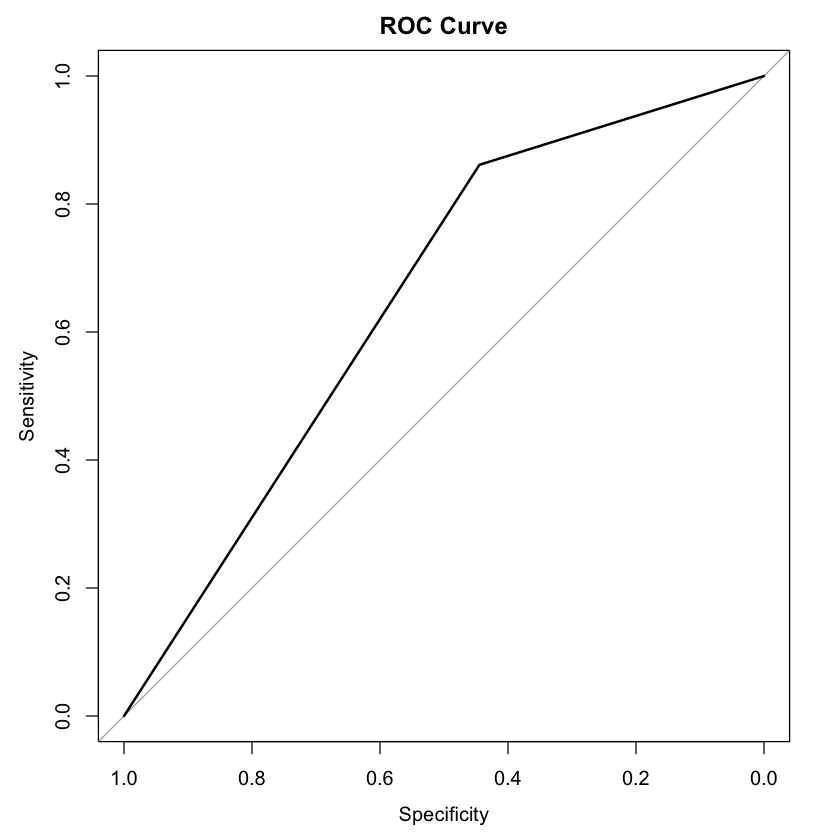

In [58]:
AUC <- roc(test$V21, yhat2)
plot(AUC, main = "ROC Curve")
AUC

In [59]:
##it can be seen that we have slight improvement in AUC 0.6884

In [69]:
### finding the threshold
results <- vector("list",92)


#reason for using 8 to 95 is at values close to zero or one, we get only one column
# see link 
#https://stackoverflow.com/questions/32940593/subscript-out-of-bounds-error-while-computing-accuracy-at-different-cutoffs
for (i in seq(8,95, by=1)){
    thresh <- i/100
    yhat <- as.integer(yhat_logit_feature_selection > thresh)
    table <- as.matrix(table(yhat, test$V21))
    cost <- table[2,1] + 5*table[1,2]
    results[i] <- cost
}

In [70]:
results

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
[1] 61

[[9]]
[1] 61

[[10]]
[1] 61

[[11]]
[1] 60

[[12]]
[1] 60

[[13]]
[1] 59

[[14]]
[1] 63

[[15]]
[1] 63

[[16]]
[1] 63

[[17]]
[1] 62

[[18]]
[1] 62

[[19]]
[1] 62

[[20]]
[1] 67

[[21]]
[1] 67

[[22]]
[1] 66

[[23]]
[1] 66

[[24]]
[1] 66

[[25]]
[1] 70

[[26]]
[1] 74

[[27]]
[1] 73

[[28]]
[1] 71

[[29]]
[1] 70

[[30]]
[1] 70

[[31]]
[1] 69

[[32]]
[1] 68

[[33]]
[1] 83

[[34]]
[1] 82

[[35]]
[1] 82

[[36]]
[1] 82

[[37]]
[1] 87

[[38]]
[1] 86

[[39]]
[1] 89

[[40]]
[1] 93

[[41]]
[1] 92

[[42]]
[1] 92

[[43]]
[1] 93

[[44]]
[1] 98

[[45]]
[1] 102

[[46]]
[1] 105

[[47]]
[1] 120

[[48]]
[1] 125

[[49]]
[1] 130

[[50]]
[1] 130

[[51]]
[1] 140

[[52]]
[1] 144

[[53]]
[1] 147

[[54]]
[1] 150

[[55]]
[1] 150

[[56]]
[1] 155

[[57]]
[1] 160

[[58]]
[1] 165

[[59]]
[1] 174

[[60]]
[1] 174

[[61]]
[1] 178

[[62]]
[1] 182

[[63]]
[1] 197

[[64]]
[1] 211

[[65]]
[1] 220

[[66]]
[1] 224

[[67]]
[1] 232

[[68]]
[1] 228

[[69]]
[1] 231

[[70]]
[1] 231

[[71]]
[1] 230

[[72]]
[1] 234

[[73]]
[1] 234

[[74]]
[1] 244

[[75]]
[1] 253

[[76]]
[1] 271

[[77]]
[1] 280

[[78]]
[1] 290

[[79]]
[1] 304

[[80]]
[1] 319

[[81]]
[1] 329

[[82]]
[1] 344

[[83]]
[1] 359

[[84]]
[1] 367

[[85]]
[1] 371

[[86]]
[1] 380

[[87]]
[1] 405

[[88]]
[1] 420

[[89]]
[1] 420

[[90]]
[1] 434

[[91]]
[1] 459

[[92]]
[1] 508

[[93]]
[1] 531

[[94]]
[1] 546

[[95]]
[1] 566

In [62]:
##The minimum cost is obtained at threshold of cutoff of 0.25
yhat_logit_feature_selection <- predict(logistic_feature_selection, test, type = "response")
yhat3 <- as.integer(yhat_logit_feature_selection > 0.25)
table(yhat3, test$V21)

     
yhat3   0   1
    0   8   3
    1  55 134


Call:
roc.default(response = test$V21, predictor = yhat3)

Data: yhat3 in 63 controls (test$V21 0) < 137 cases (test$V21 1).
Area under the curve: 0.5525

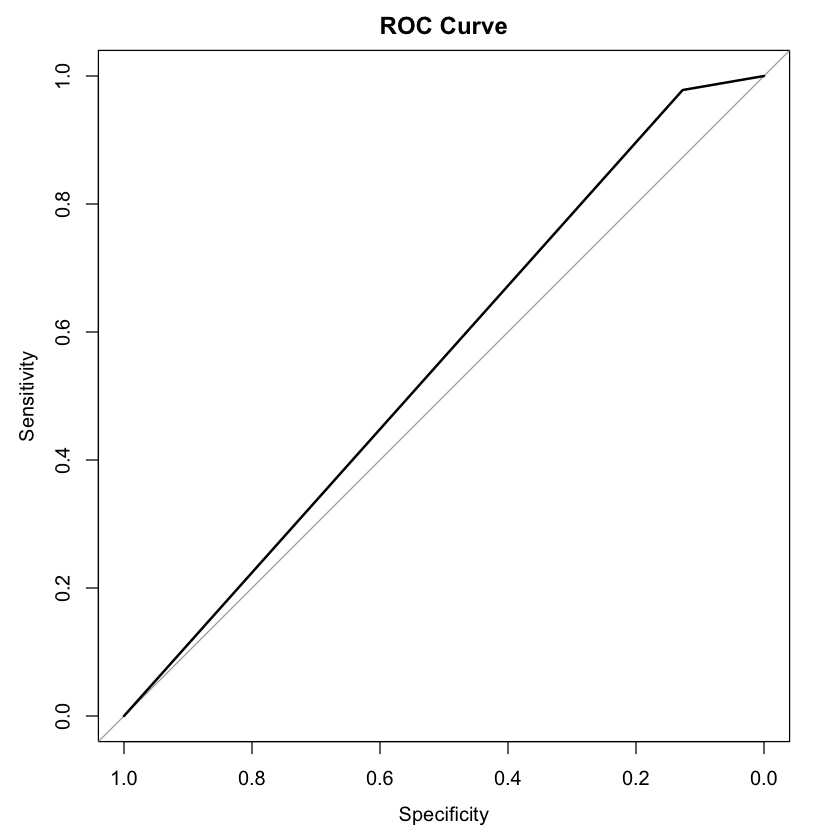

In [63]:
AUC <- roc(test$V21, yhat3)
plot(AUC, main = "ROC Curve")
AUC

In [71]:
#please note that each run of the program gives different results for threshold due to different seeds.